In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ln -s /content/drive/My\ Drive/ /my\drive

ln: failed to create symbolic link '/mydrive/My Drive': File exists


In [3]:
#파이토치 불러오기
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
!pip3 install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl

In [4]:
!pip uninstall -y Pillow
!pip install "pillow<6.2.2"

Uninstalling Pillow-6.2.1:
  Successfully uninstalled Pillow-6.2.1
  Using cached https://files.pythonhosted.org/packages/10/5c/0e94e689de2476c4c5e644a3bd223a1c1b9e2bdb7c510191750be74fa786/Pillow-6.2.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [5]:
!pip install torchvision

In [11]:
import torch
import torch.nn.functional as F
from torchvision import transforms, models

from PIL import Image
import json

import matplotlib.pyplot as plt

In [12]:
model = models.resnet101(pretrained=True)
model.eval()
print(model)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:02<00:00, 85130904.64it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [15]:
CLASSES = json.load(open('/content/drive/My Drive/특강/Pytorch/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]

In [18]:
img = Image.open('/content/drive/My Drive/특강/Pytorch/schuna.jpg')

In [20]:
#이미지를 텐서로 변환
img_transforms = transforms.Compose([
                                     transforms.Resize((224,224), Image.BICUBIC),
                                     transforms.ToTensor(),
])

img_tensor = img_transforms(img)
img_tesnsor = img_tensor.unsqueeze(0)

print("Image Tensor : ", img_tensor.size())

Image Tensor :  torch.Size([3, 224, 224])


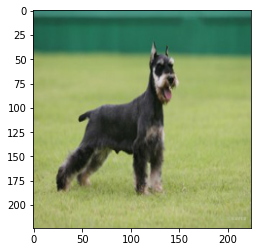

In [27]:
#차원을 늘려줬던 텐서를 넘파이 행렬로 변환 -> matplot라이브러리와 호환 -> 이미지 시각화

original_img_view = img_tensor.squeeze(0).detach()
original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy()

#텐서 시각화
plt.imshow(original_img_view)

In [32]:
#모델의 성능을 체크한다
output = model(img_tensor.unsqueeze(0)) #input image(img_tensor)가 3차원이라서 한번 더 unsqueeze하여 4차원으로 만들어주었다.
prediction = output.max(1, keepdim=False)[1]

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print("Predicted No.:", prediction_idx)
print('Predicted Name :', prediction_name)

Predicted No.: 198
Predicted Name : standard schnauzer


In [37]:
def fgsm_attack(iamge, epsilon, gradient):
  #기울기의 사인 값을 구한다
  sign_gradient = gradient.sign()

  #이미지 각 칙셀의 값을 sign_gradient 방향으로 입실론 만큼 조절한다
  perturbed_image = img_tensor.unsqueeze(0)+epsilon*sign_gradient

  #[0,1] 범위를 벗어나는 값을 조절해준다
  perturbed_image = torch.clamp(perturbed_image, 0, 1)
  return perturbed_image

In [38]:
#원본 이미지의 기울기 구하기
img_tensor.requires_grad_(True)

#이미지를 모델에 통과시켜 결과값 도출하기
output = model(img_tensor.unsqueeze(0))

#원본 이미지와 결과값의 오차 구하기
loss  = F.nll_loss(output, torch.tensor([196]))

#기울기값 구하기
model.zero_grad()
loss.backward()

#이미지의 기울기값 추출하기
gradient = img_tensor.grad.data

#FGSM 공격으로 적대적 예제 생성
#입실론 값은 0과 1 사이의 아주 작은 값이다.
epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)

#생성된 적대적 예제를 모델에 통과시킨다
output = model(perturbed_data)

In [39]:
perturbed_prediction = output.max(1, keepdim=True)[1]

perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]

print("Predicted No. :", perturbed_prediction_idx )
print("Predicted Name :",perturbed_prediction_name)

Predicted No. : 701
Predicted Name : parachute, chute


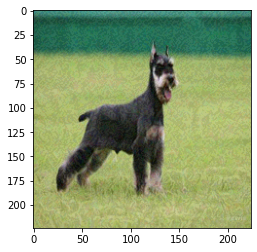

In [42]:
#시각화를 위해 넘파이 행렬로 변환
perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.transpose(0,2).transpose(0,1).numpy()

plt.imshow(perturbed_data_view)

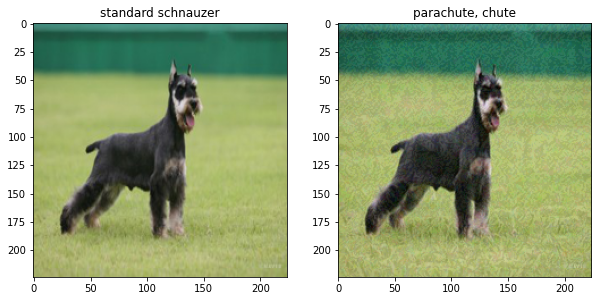

In [44]:
#원본과 적대적 예제를 비교한다
f, a = plt.subplots(1,2,figsize=(10,10))

#원본
a[0].set_title(prediction_name)
a[0].imshow(original_img_view)

#적대적 예제
a[1].set_title(perturbed_prediction_name)
a[1].imshow(perturbed_data_view)

plt.show()